In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format='svg'

import numpy as np
np.set_printoptions(precision=6, suppress=True)
np.set_printoptions(threshold=np.inf)

import shl_scripts.shl_tools
from shl_scripts.shl_experiments import SHL

import DNN.mnist_loader as data_loader
import DNN.network as network
from shl_scripts.shl_encode import sparse_encode

In [2]:
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [3]:
training_data,validation_data,test_data=data_loader.load_data()
training_image = training_data[0]
training_supervision = training_data[1]
test_image = test_data[0]
test_supervision = test_data[1]

In [4]:
tag ='2017-05-26_MNIST_SN_'
DEBUG_DOWNSCALE, verbose = 1, 10
tag ='2017-05-30_MNIST_SN_DEBUG_'
DEBUG_DOWNSCALE, verbose = 10, 10
patch_size = (28,28)
n_dictionary = 15**2
l0_sparseness = 15
n_iter = 2**16
eta = 0.01
eta_homeo = 0.01
alpha_homeo = 0.02
n_hidden = 30
list_figures=['show_dico']

No cache found /tmp/data_cache/2017-05-30_MNIST_SN_DEBUG_n_dictionary144_dico.pkl: Learning the dictionary with algo = mp 
 Training on 50000 patches... Iteration   0 /   6553 (elapsed time:   0s,  0.0mn)
Iteration  656 /   6553 (elapsed time:  77s,  1.0mn)
Iteration  1312 /   6553 (elapsed time:  165s,  2.0mn)
Iteration  1968 /   6553 (elapsed time:  252s,  4.0mn)
Iteration  2624 /   6553 (elapsed time:  344s,  5.0mn)
Iteration  3280 /   6553 (elapsed time:  439s,  7.0mn)
Iteration  3936 /   6553 (elapsed time:  534s,  8.0mn)
Iteration  4592 /   6553 (elapsed time:  637s,  10.0mn)
Iteration  5248 /   6553 (elapsed time:  736s,  12.0mn)
Iteration  5904 /   6553 (elapsed time:  834s,  13.0mn)
Learning code... done (total time:  923s,  15.4mn)
done in 924.12s.
No cache found /tmp/data_cache/2017-05-30_MNIST_SN_DEBUG_n_dictionary144_coding.npy: Coding with algo = mp 
 Coding data with algorithm  mp done in 10.14s.


ValueError: cannot reshape array of size 144 into shape (225,1)

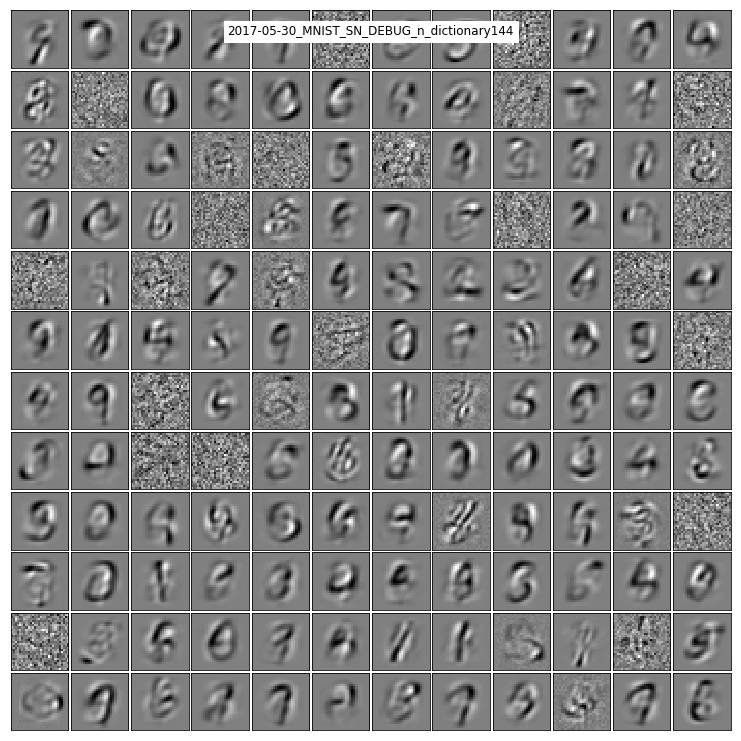

In [5]:
for n_dictionary_ in np.arange(12, 30, 3)**2:
    shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, 
                eta = eta, eta_homeo = eta_homeo, verbose = verbose, 
                n_iter = n_iter, patch_size = patch_size, l0_sparseness=l0_sparseness, alpha_homeo = alpha_homeo,
                n_dictionary = n_dictionary_) #record_each=1000)
    matname = tag + 'n_dictionary' + str(n_dictionary_)
    dico = shl.learn_dico(data=training_image, matname=matname,list_figures=list_figures)    
    ## formating the date to fit theano standard
    training_sparse_vector = shl.code(data=training_image, dico=dico, matname=matname)
    test_sparse_vector = sparse_encode(test_image, dico.dictionary, algorithm = shl.learning_algorithm,
                                l0_sparseness = shl.l0_sparseness, fit_tol = None,
                                P_cum = dico.P_cum, verbose = 0)
    wrapped_training_data = (training_sparse_vector, training_supervision)
    wrapped_test_data = (test_sparse_vector, test_supervision)
    
    wrapped_inputs = [np.reshape(x, (n_dictionary, 1)) for x in wrapped_training_data[0]]
    wrapped_results = [vectorized_result(y) for y in wrapped_training_data[1]]
    wrapped_training_data = zip(wrapped_inputs, wrapped_results)
    wrapped_test_inputs = [np.reshape(x, (n_dictionary, 1)) for x in wrapped_test_data[0]]
    wrapped_test_data_final = zip(wrapped_test_inputs, wrapped_test_data[1])
    
    print(" ----- learning for the dico of size : {0} -----".format(n_dictionary))
    ## running the network
    net = network.Network([n_dictionary, n_hidden, 10])
    net.SGD(training_data=wrapped_training_data,
       epochs=30,
       mini_batch_size=10,
       eta=3.0,
       test_data=wrapped_test_data_final)



In [ ]:
for l0_sparseness_ in np.arange(5, 40, 5):
    shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, 
                eta = eta, eta_homeo = eta_homeo, verbose=verbose, alpha_homeo = alpha_homeo,
                n_iter = n_iter, patch_size = patch_size, l0_sparseness = l0_sparseness_,
                n_dictionary = n_dictionary) #record_each=1000)
    
    matname = tag + 'l0_sparseness=' + str(l0_sparseness_)
    dico = shl.learn_dico(data=training_image,matname=matname, list_figures=list_figures)
    
    training_sparse_vector = shl.code(data=training_image, dico=dico, matname=matname)
    test_sparse_vector = sparse_encode(test_image, dico.dictionary, algorithm = shl.learning_algorithm,
                                l0_sparseness = shl.l0_sparseness, fit_tol = None,
                                P_cum = dico.P_cum, verbose = 0)
    wrapped_training_data = (training_sparse_vector, training_supervision)
    wrapped_test_data = (test_sparse_vector, test_supervision)
    
    wrapped_inputs = [np.reshape(x, (shl.n_dictionary, 1)) for x in wrapped_training_data[0]]
    wrapped_results = [vectorized_result(y) for y in wrapped_training_data[1]]
    wrapped_training_data = zip(wrapped_inputs, wrapped_results)
    wrapped_test_inputs = [np.reshape(x, (shl.n_dictionary, 1)) for x in wrapped_test_data[0]]
    wrapped_test_data_final = zip(wrapped_test_inputs,wrapped_test_data[1])
    
    print(" ----- learning for the dico of sparseness: {0} -----".format(l0_sparseness))
    ## running the network
    net = network.Network([shl.n_dictionary, n_hidden, 10])
    net.SGD(training_data=wrapped_training_data,
       epochs=30,
       mini_batch_size=10,
       eta=3.0,
       test_data=wrapped_test_data_final)